In [1]:
!pip install fuzzy-c-means
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from fcmeans import FCM
from sklearn.svm import SVC
from sklearn.utils import shuffle
import statsmodels.api as sm 
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Importing required modules
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

***Read data*** 


In [3]:
data=pd.read_csv("/content/heart_failure_clinical_records_dataset.csv")

***describe data***

In [4]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


***check the null values***

In [5]:
data.isnull(). values. any()

False

In [6]:
data=data.drop(["platelets","creatinine_phosphokinase"],axis=1)

In [7]:
data.shape

(299, 11)

In [8]:
# def find_outliers_IQR(df):

#     q1=df.quantile(0.25)

#     q3=df.quantile(0.75)

#     IQR=q3-q1

#     outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

#     return outliers

In [9]:
# for i in data.columns:
#     outliers = find_outliers_IQR(data[i])
#     print(f'outliers of coulmn {i}')
#     print()
#     print("number of outliers:" + str(len(outliers)))
#     print("max outlier value: "+ str(outliers.max()))
#     print("min outlier value: " + str(outliers.min()))
#     print('')
#     print('-------------------------------------------')

In [10]:
# def find_outliers_Index(df,col):

#     q1=df[col].quantile(0.25)

#     q3=df[col].quantile(0.75)

#     IQR=q3-q1

#     outliers = df.index[((df[col]<(q1-1.5*IQR)) | (df[col]>(q3+1.5*IQR)))]

#     return outliers

In [11]:
# index_=[]
# for col in data.columns:
#     index_.extend(find_outliers_Index(data,col))
# index_

In [12]:
# def remove_outliers(df,lst):
#     lst=sorted(set(lst))
#     df=df.drop(lst)
#     return df

In [13]:
# data=remove_outliers(data,index_)
# data

***split the cont and bin features***

In [14]:
discrete_features, continuous_features = [], []
for feature in data.columns:
    if feature == 'DEATH_EVENT':
        label = feature
    elif len(data[feature].unique()) > 2:
        continuous_features.append(feature)
    else:
        discrete_features.append(feature)

print('Discrete: ', discrete_features, '\n', 'Continuous:', continuous_features, '\n', 'Label:', label)

Discrete:  ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking'] 
 Continuous: ['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time'] 
 Label: DEATH_EVENT


In [15]:
data[discrete_features].head()

,anaemia,diabetes,high_blood_pressure,sex,smoking
0,0,0,1,1,0
1,0,0,0,1,0
2,0,0,0,1,1
3,1,0,0,1,0
4,1,1,0,0,0


In [16]:
data[continuous_features].head()

,age,ejection_fraction,serum_creatinine,serum_sodium,time
0,75.0,20,1.9,130,4
1,55.0,38,1.1,136,6
2,65.0,20,1.3,129,7
3,50.0,20,1.9,137,7
4,65.0,20,2.7,116,8


***scaling cont features***

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(data[continuous_features])
scaled_continuous_features = scaler.transform(data[continuous_features])
scaled_continuous_features = pd.DataFrame(data=scaled_continuous_features, columns=['age','creatinine_phosphokinase', 'ejection_fraction', 'serum_sodium', 'time' ])
scaled_continuous_features.head()

,age,creatinine_phosphokinase,ejection_fraction,serum_sodium,time
0,0.636364,0.090909,0.157303,0.485714,0.000000
1,0.272727,0.363636,0.067416,0.657143,0.007117
2,0.454545,0.090909,0.089888,0.457143,0.010676
3,0.181818,0.090909,0.157303,0.685714,0.010676
4,0.454545,0.090909,0.247191,0.085714,0.014235


***concatenate all fature***

In [18]:
scaled_data = pd.concat([data[discrete_features], scaled_continuous_features, data['DEATH_EVENT']], axis=1)
scaled_data.describe()

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,creatinine_phosphokinase,ejection_fraction,serum_sodium,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000
mean,0.431438,0.418060,0.351171,0.648829,0.32107,0.378798,0.364903,0.100436,0.675012,0.449327,0.32107
std,0.496107,0.494067,0.478136,0.478136,0.46767,0.216269,0.179316,0.116237,0.126071,0.276207,0.46767
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.200000,0.242424,0.044944,0.600000,0.245552,0.00000
50%,0.000000,0.000000,0.000000,1.000000,0.00000,0.363636,0.363636,0.067416,0.685714,0.395018,0.00000
75%,1.000000,1.000000,1.000000,1.000000,1.00000,0.545455,0.469697,0.101124,0.771429,0.708185,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [19]:
scaled_data

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,creatinine_phosphokinase,ejection_fraction,serum_sodium,time,DEATH_EVENT
0,0,0,1,1,0,0.636364,0.090909,0.157303,0.485714,0.000000,1
1,0,0,0,1,0,0.272727,0.363636,0.067416,0.657143,0.007117,1
2,0,0,0,1,1,0.454545,0.090909,0.089888,0.457143,0.010676,1
3,1,0,0,1,0,0.181818,0.090909,0.157303,0.685714,0.010676,1
4,1,1,0,0,0,0.454545,0.090909,0.247191,0.085714,0.014235,1
...,...,...,...,...,...,...,...,...,...,...,...
294,0,1,1,1,1,0.400000,0.363636,0.067416,0.857143,0.946619,0
295,0,0,0,0,0,0.272727,0.363636,0.078652,0.742857,0.950178,0
296,0,1,0,0,0,0.090909,0.696970,0.033708,0.714286,0.975089,0
297,0,0,0,1,1,0.090909,0.363636,0.101124,0.771429,0.982206,0


In [20]:
scaled_data.isnull(). values. any()

False

***split data to target and features***

In [21]:
y=scaled_data.iloc[:,-1]
y

0      1
1      1
2      1
3      1
4      1
      ..
294    0
295    0
296    0
297    0
298    0
Name: DEATH_EVENT, Length: 299, dtype: int64

In [22]:
x=scaled_data.iloc[:,:12]
x

,anaemia,diabetes,high_blood_pressure,sex,smoking,age,creatinine_phosphokinase,ejection_fraction,serum_sodium,time,DEATH_EVENT
0,0,0,1,1,0,0.636364,0.090909,0.157303,0.485714,0.000000,1
1,0,0,0,1,0,0.272727,0.363636,0.067416,0.657143,0.007117,1
2,0,0,0,1,1,0.454545,0.090909,0.089888,0.457143,0.010676,1
3,1,0,0,1,0,0.181818,0.090909,0.157303,0.685714,0.010676,1
4,1,1,0,0,0,0.454545,0.090909,0.247191,0.085714,0.014235,1
...,...,...,...,...,...,...,...,...,...,...,...
294,0,1,1,1,1,0.400000,0.363636,0.067416,0.857143,0.946619,0
295,0,0,0,0,0,0.272727,0.363636,0.078652,0.742857,0.950178,0
296,0,1,0,0,0,0.090909,0.696970,0.033708,0.714286,0.975089,0
297,0,0,0,1,1,0.090909,0.363636,0.101124,0.771429,0.982206,0


In [23]:
pca = PCA(2)
df = pca.fit_transform(x)
df.shape

(299, 2)

In [24]:
x_train,x_test,y_train,y_test = train_test_split( x, y, test_size=0.2)

***apply elbow method to get the best num of clusters***

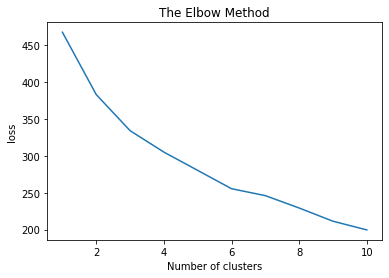

In [25]:
import matplotlib.pyplot as plt
loss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    loss.append(kmeans.inertia_)
plt.plot(range(1, 11), loss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('loss')
plt.show()

***train the model***

In [26]:
#kmeans = KMeans(n_clusters=2,random_state=45)

#kmeans.fit(x)

# check how many of the samples were correctly labeled
#labels = kmeans.labels_



In [27]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 2)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
print(label)
correct_labels = sum(y == label)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
k_acc=correct_labels/float(y.size)*100
k_acc

[0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1
 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0
 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0
 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0
 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0
 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0
 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1
 0 0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1
 1 0 0]
Result: 144 out of 299 samples were correctly labeled.


48.16053511705686

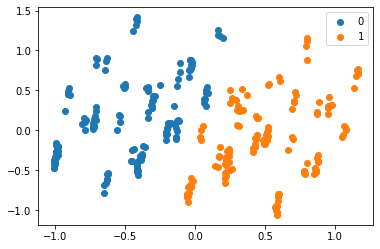

In [28]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

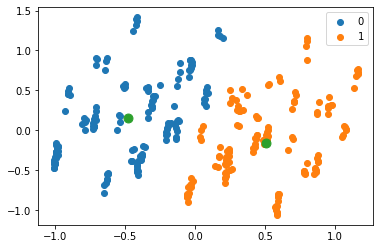

In [29]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80)
plt.legend()
plt.show()

In [30]:
kmeans.cluster_centers_

array([[-0.47993832,  0.15257963],
       [ 0.5097276 , -0.16205009]])

In [31]:
import pandas as pd
label=pd.DataFrame(label)
label.columns=["labels"]
label.value_counts()

labels
0         154
1         145
dtype: int64

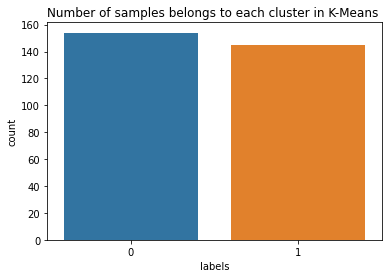

In [32]:
import seaborn as sns 
sns.countplot(data=label,x="labels").set(title='Number of samples belongs to each cluster in K-Means ')
plt.show()

***Apply fuzzy c mean clustring***

In [33]:
import numpy as np
m = FCM(n_clusters=2,m=1.7,maxiter=100,random_state=45)
xm=np.array(x)
m.fit(xm)
y_pred=m.soft_predict(xm)
y_pred
# check how many of the samples were correctly labeled


array([[0.47697726, 0.52302274],
       [0.42428198, 0.57571802],
       [0.33944104, 0.66055896],
       [0.4918705 , 0.5081295 ],
       [0.63234575, 0.36765425],
       [0.44379457, 0.55620543],
       [0.49116988, 0.50883012],
       [0.4662128 , 0.5337872 ],
       [0.55595655, 0.44404345],
       [0.45526246, 0.54473754],
       [0.44082398, 0.55917602],
       [0.38666988, 0.61333012],
       [0.49255212, 0.50744788],
       [0.53022839, 0.46977161],
       [0.63017458, 0.36982542],
       [0.49406887, 0.50593113],
       [0.4930135 , 0.5069865 ],
       [0.43356788, 0.56643212],
       [0.61912463, 0.38087537],
       [0.64286359, 0.35713641],
       [0.63161453, 0.36838547],
       [0.66979793, 0.33020207],
       [0.43548012, 0.56451988],
       [0.50004834, 0.49995166],
       [0.63322653, 0.36677347],
       [0.41422219, 0.58577781],
       [0.60617498, 0.39382502],
       [0.45155757, 0.54844243],
       [0.49371563, 0.50628437],
       [0.41376335, 0.58623665],
       [0.

In [34]:
"""def alpcut1(alpha,y_fuzzy):
  for i in range(1):
    for m in y_fuzzy:
      if y_fuzzy[m][i]>alpha:
        y_fuzzy[m][i]==1 and y_fuzzy[m][i]==0
      else:
        y_fuzzy[m][i]==1 and y_fuzzy[m][i]==0
      return(np.argmax(y_fuzzy[i]))"""

'def alpcut1(alpha,y_fuzzy):\n  for i in range(1):\n    for m in y_fuzzy:\n      if y_fuzzy[m][i]>alpha:\n        y_fuzzy[m][i]==1 and y_fuzzy[m][i]==0\n      else:\n        y_fuzzy[m][i]==1 and y_fuzzy[m][i]==0\n      return(np.argmax(y_fuzzy[i]))'

***calculate alpha cut to get crisp values(labels)***

In [35]:
def alph_cut(alpha,y_fuzzy):
  #alpha=.4
  labels=[]
  count=len(y_fuzzy)
  for i in range(count):
    if (alpha<=y_fuzzy[i][0]):
      labels.append(0)
    else:
      labels.append(1)
  return labels

In [36]:
alph_cut(0.5,y_pred)

[1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,


***alpha cut =0.2***

In [37]:
labels = alph_cut(0.2,y_pred)
#label=np.array(labels)
correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
c_acc= correct_labels/float(y.size)*100
c_acc

Result: 203 out of 299 samples were correctly labeled.


67.89297658862876

***alpha cut =0.3***

In [38]:
labels = alph_cut(0.3,y_pred)
#label=np.array(labels)
correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
c_acc= correct_labels/float(y.size)*100
c_acc

Result: 177 out of 299 samples were correctly labeled.


59.19732441471572

***alpha cut =0.4***

In [39]:
labels = alph_cut(0.4,y_pred)
#label=np.array(labels)
correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
c_acc= correct_labels/float(y.size)*100
c_acc

Result: 152 out of 299 samples were correctly labeled.


50.836120401337794

***alpha cut =0.7***

In [40]:
labels = alph_cut(0.7,y_pred)
#label=np.array(labels)
correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
c_acc= correct_labels/float(y.size)*100
c_acc

Result: 98 out of 299 samples were correctly labeled.


32.77591973244147

***alpha cut =0.8***

In [41]:
labels = alph_cut(0.8,y_pred)
#label=np.array(labels)
correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
c_acc= correct_labels/float(y.size)*100
c_acc

Result: 96 out of 299 samples were correctly labeled.


32.10702341137124

***alpha cut=0.1***

In [42]:
labels = alph_cut(0.1,y_pred)
#label=np.array(labels)
correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
c_acc= correct_labels/float(y.size)*100
c_acc
l=alph_cut(0.4,y_pred)
l=pd.DataFrame(l)
l
l.columns=["l"]


Result: 203 out of 299 samples were correctly labeled.


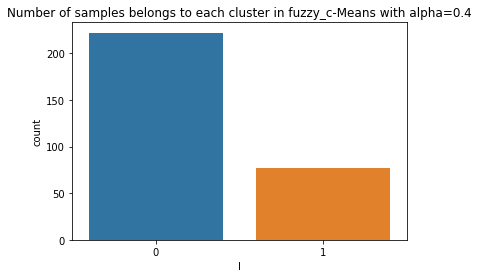

In [43]:
l.value_counts()
import seaborn as sns 
sns.countplot(data=l,x="l").set(title='Number of samples belongs to each cluster in fuzzy_c-Means with alpha=0.4')
plt.show()

In [44]:
# Instantiate the Support Vector Classifier (SVC)
from sklearn.metrics import confusion_matrix
svc = SVC(C=1.0, random_state=45, kernel='linear') 

# Fit the model
svc.fit(x_train, y_train)

# Make the predictions
y_predict = svc.predict(x_test)

# Measure the performance
SVM_accuracy=accuracy_score(y_test, y_predict)*100
print("Accuracy score : ",SVM_accuracy)
f=confusion_matrix(y_test,y_predict)
f

Accuracy score :  100.0


array([[45,  0],
       [ 0, 15]])

In [45]:
Models=["Fuzzy C-Means","K-Means","SVM"]
model_data = [c_acc  , k_acc, SVM_accuracy]
cols = ["Accuracy_score"]
compare=pd.DataFrame(data=model_data , index= Models , columns= cols)
compare.sort_values(ascending= False , by = ['Accuracy_score'])

,Accuracy_score
SVM,100.000000
Fuzzy C-Means,67.892977
K-Means,48.160535


In [46]:
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = reg_strength * (np.sum(distances) / N)
    
    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost

In [47]:
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])
    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))
    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (reg_strength * Y_batch[ind] * X_batch[ind])
        dw += di

In [48]:
def sgd(features, outputs):
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    # stochastic gradient descent
    for epoch in range(1, max_epochs): 
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent)
            
    return weights

In [49]:
# # train the model
# print("training started...")
# W = sgd(x_train.to_numpy(), y_train.to_numpy())
# print("training finished.")
# print("weights are: {}".format(W))

In [50]:
def sgd(features, outputs):
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent)
        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is:{} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            if abs(prev_cost - cost) < cost_threshold * prev_cost:
                return weights
            prev_cost = cost
            nth += 1
    return weights

In [52]:
# # testing the model on test set
# y_test_predicted = np.array([])
# for i in range(x_test.shape[0]):
#     yp = np.sign(np.dot(W, x_test.to_numpy()[i])) #model
#     y_test_predicted = np.append(y_test_predicted, yp)
# print("accuracy on test dataset: {}".format(accuracy_score(y_test.to_numpy(), y_test_predicted)))
# print("recall on test dataset: {}".format(recall_score(y_test.to_numpy(), y_test_predicted)))
# print("precision on test dataset: {}".format(recall_score(y_test.to_numpy(), y_test_predicted)))